## <font color='navy'>Data Challenge Description</font>

A data scientist at company XYZ noticed that France-based users have a **much higher conversion rate** than any other French-speaking country. She therefore went and talked to the international team in charge of France And French-speaking countries to see if they had any ideas about why that was happening.

The France and French-speaking countries manager suggested that **one reason could be the translation**. All French-speaking countries had the same translation of the site which was written by a French person. They agreed to try a **test where each country would have its one translation written by a local**. That is, Moroccan users would see a translation written by a Moroccan, Canadian user by a Canadian, and so on. Obviously, nothing would change for users from France
After they run the test, however, they are really surprised as the test is **negative**. That is, it appears that the non-localized translation was doing better!

You are asked to:
1.	Reproduce the original negative result. **<font color='teal'>Is it actually negative?</font>**
2.	Explain why that might be happening. **<font color='teal'>Are the localized translations really worse?</font>**
3.	If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

## <font color='navy'>ِDatasets and Variables</font>

**test_data_table(browsing behavior data)**

- ``user_id``: the id of the user.
- ``date``: when they came to the site
- ``source``: marketing channel
- ``device``: device used by the user.
- ``browser_language``: in browser or app settings, the language chosen by the user. It can be EN, FR, Other (Other means any language except for English and French) 
- ``ads_channel``: if marketing channel is ads, this is the site where the ad was displayed.
- ``browser``: user browser.
- ``conversion``: whether the user converted (1) or not (0). **A test is considered successful if it increases the proportion of users who convert.** 
- ``test``: users are randomly split into test (1) and control (0). Test users see the new translation and control the old one.

**user_data_table(demographic_data)**
- ``user_id``: the id of the user. It can be joined to user id in the other table
- ``sex``: user sex: Male or Female
- ``age``: user age (self-reported)
- ``country``: user country based on IP address

## <font color='navy'>ِRequired libraries</font>

In [1]:
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for visualization purposes
from scipy.stats import chi2_contingency # to perform chi-square test
from statsmodels.graphics.mosaicplot import mosaic # to perfomr VEDA between categorical variables
import numpy as np
import seaborn as sns
sns.set() # inline plots with seaborn style

In [2]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12,6

## <font color='navy'>Importing Data</font>

In [3]:
test = pd.read_csv('test_data_table.csv') # importing browsing behavior data
ID = pd.read_csv('user_data_table.csv') # importing demographic information.

In [4]:
test.head() # seeing a lookg at first five rows of the browsing behaviour

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,FR,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,FR,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,FR,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,FR,Google,FireFox,0,1


There is a date in the data set, I like to bring it to datetime format so that I can use the time-series functionality of pandas in my EDA.

In [5]:
test['date'] = pd.to_datetime(test['date'],infer_datetime_format=True)

In [6]:
ID.head() # taking a look at first five rows of ID

,user_id,sex,age,country
0,765821,M,20,Democratic Republic of the Congo
1,343561,F,27,Luxembourg
2,118744,M,23,Canada
3,987753,F,27,Switzerland
4,554597,F,20,France


I like to join the data sets together to have a comprehenssive data set to work on. This simplifies the EDA and saves times. We need to join on test data as it is the data we want to analyze and we'd like to keep all of its ids. Before joining, let's quickly check if IDs match between the two data sets.

I want to see how many users in test set have demographic data?

## <font color='navy'>Joining Tables</font>

In [7]:
test_ids = set(test.user_id) # user ids in behavioral data set
id_ids = set(ID.user_id) # user ids in demographic data set 
non_identified_users = test_ids - id_ids
non_identified_ratio = round(len(non_identified_users)/len(test_ids)*100,3)
print("{} % of the users in test data set don't have demographic info".format(non_identified_ratio))

0.1 % of the users in test data set don't have demographic info


**<font color='maroon'>Request product engineers to explore the cause.</font>**

In [8]:
test_id = test.merge(ID, on='user_id', how='left')
test_id.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,FR,NaN,IE,1,0,M,32.0,France
1,497851,2015-12-04,Ads,Web,FR,Google,IE,0,1,M,21.0,Democratic Republic of the Congo
2,848402,2015-12-04,Ads,Web,FR,Facebook,Chrome,0,0,M,34.0,France
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Democratic Republic of the Congo
4,548435,2015-11-30,Ads,Web,FR,Google,FireFox,0,1,M,19.0,Democratic Republic of the Congo


In [9]:
test_id['country'] = test_id['country'].str.replace("Democratic Republic of the Congo","Congo")\
.replace("Republic of the Congo","Congo")

## <font color='navy'>Exploratory Data Analysis</font>

**<font color='teal'>shape:</font>**

In [10]:
print(" Test Data has {0} rows and {1} columns.".format(test_id.shape[0],test_id.shape[1]))

 Test Data has 453321 rows and 12 columns.


**<font color='teal'>summary:</font>**

In [11]:
test_id.info() # seeing the number of objects and the number of null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 45.0+ MB


**<font color='purple'>observation:</font>**

- ``sex``,``age``, ``country`` have missing values. These are the demographic data that wasn't joined from the ID table as they didnt have a correspoding ID ($<0.1\%$).

**<font color='teal'>descriptive statistics:</font>**

- numerical feature

In [12]:
test_id.describe() # provides the statistical analysis of the numerical features

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


**<font color='purple'>observation:</font>**
    
- Coversion rate is 5.0 % which is close to industry standard.
- Around 47.6 % of the users are in the test set.
- Users come from a young population. Their 3rd quantile is 31.

**<font color='teal'>descriptive statistics:</font>**

- categorical feature

In [13]:
test_id.describe(include = ['O']) # provides the statistical analysis of the categrorical variables

,source,device,browser_language,ads_channel,browser,sex,country
count,453321,453321,453321,181877,453321,452867,452867
unique,3,2,3,5,7,2,16
top,Ads,Web,FR,Facebook,Android_App,M,Congo
freq,181877,251565,377547,68425,155135,264485,136659


**<font color='purple'>observation:</font>**
- There are 3 marketing channels, and 'Ads' is the most popular.
- Most of the users are Male.
- There are 16 countries in the dataset. Oddly more than 1/4 of activities come from a single country.

**<font color='teal'>descriptive statistics:</font>**

- date

In [14]:
test_id['date'].describe()

count                  453321
unique                      5
top       2015-12-04 00:00:00
freq                   141163
first     2015-11-30 00:00:00
last      2015-12-04 00:00:00
Name: date, dtype: object

**<font color='purple'>observation:</font>**

- Test runs for 5 days (November 30th, 2015 to December 4th, 2015) **<font color='teal'>which is a pretty narrow for generalizing the results and capture any seasonality.</font>**


## <font color='navy'>Visualized Exploratory Data Analysis</font>

- **<font color='teal'>What is the click quality of each channel?</font>**

             conversion
ads_channel            
Other          5.011287
Google         5.473708
Bing           5.505994
Yahoo          5.514272
Facebook       5.677722


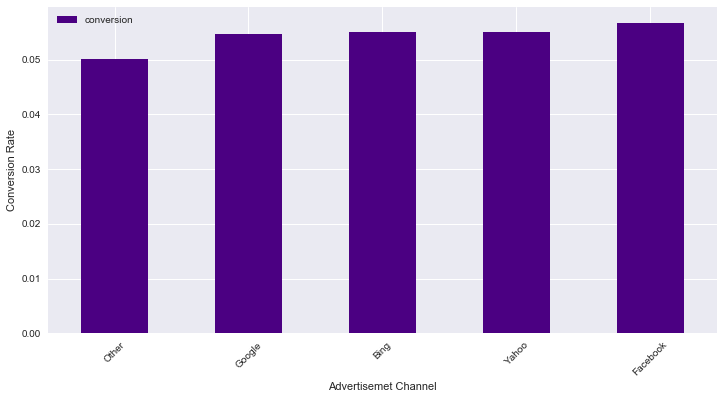

In [15]:
advertisers = test_id[(test_id.source == 'Ads') & (test_id.test == 0)] # assuming no change occurs
summary_ads = advertisers[['ads_channel','conversion']].groupby('ads_channel').mean().sort_values('conversion')
summary_ads.plot(kind='bar', color = 'indigo')
plt.xticks(rotation=45)
plt.xlabel("Advertisemet Channel")
plt.ylabel("Conversion Rate")
print(summary_ads*100)

- **<font color='teal'>How about countries?</font>**

Text(0,0.5,'Conversion Rate')

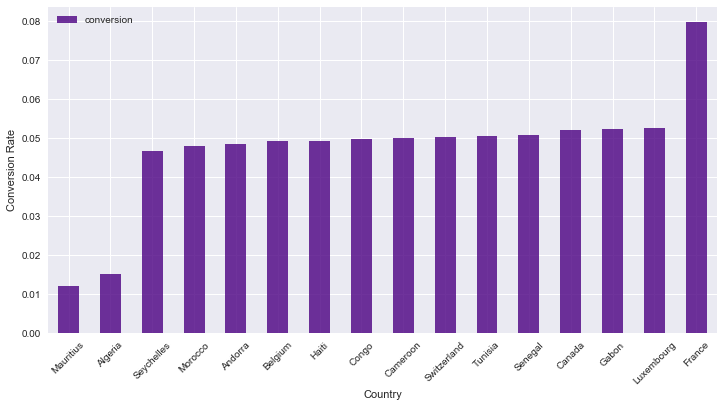

In [16]:
countries = test_id[(test_id.test == 0)] # assuming no change occurs
summary_ct = countries[['country','conversion']].groupby('country').mean().sort_values('conversion')
summary_ct.plot(kind='bar', color='indigo', alpha=0.8)
plt.xticks(rotation=45)
plt.xlabel("Country")
plt.ylabel("Conversion Rate")

<font color='purple'>France, indeed has a very high conversion rate compared to other coutries.</font>

- **<font color='teal'>َAnd gender?</font>**

,conversion
sex,
F,0.054990
M,0.055273


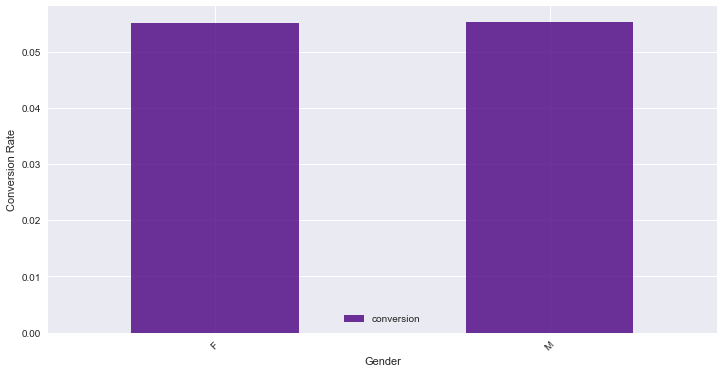

In [17]:
summary_gnd = countries[['sex','conversion']].groupby('sex').mean().sort_values('conversion')
summary_gnd.plot(kind='bar', color='indigo', alpha=0.8)
plt.xticks(rotation=45)
plt.xlabel("Gender")
plt.ylabel("Conversion Rate")
summary_gnd

- **<font color='teal'>َAnd day of the experiment?</font>**

,conversion
date,
2015-12-01,0.053616
2015-12-04,0.054122
2015-12-02,0.055364
2015-12-03,0.056094
2015-11-30,0.057374


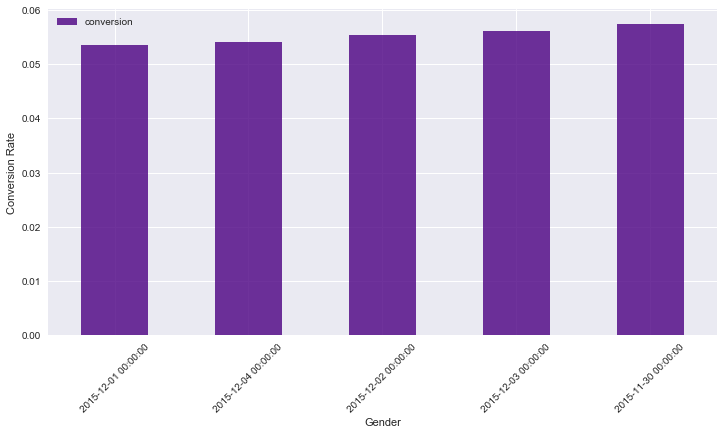

In [18]:
summary_gnd = countries[['date','conversion']].groupby('date').mean().sort_values('conversion')
summary_gnd.plot(kind='bar', color='indigo', alpha=0.8)
plt.xticks(rotation=45)
plt.xlabel("Gender")
plt.ylabel("Conversion Rate")
summary_gnd

## <font color='navy'>Q1- Reproduce negative results. Is that really negative?</font>
 
What we need to see here is simply if the coversion rate reduces after we perform the test. We use groupby to see the results, then perform a simple statistical test to assure it is significant.

In [19]:
test_id[['test','conversion']].groupby('test').mean() # checking the conversion rate for all of the customers in test/non test

,conversion
test,
0,0.055179
1,0.043425


**<font color='teal'>Tableau Results:</font>**
![Results of the A/B test](A-Btest.PNG "Conversion rate before and after test")

<font color='purple'>Indeed there is a reduction of 1.18% (5.52-4.34) in the coversion rate comparing experiment and control groups.Such reduction is practically significant in most business cases.</font>

<font color='teal'>Is this result statistically significant?</font>

In [20]:
def categorical_features_test(df, feature, target):
    observed = pd.crosstab(df[target],df[feature])    
    _, p, _, _ = chi2_contingency(observed)
    if p<0.05:
        significance = 'significant'
    else:
        significance = 'insignificant'     
    print('*'*27+' Chi-Square test results!!!'+'*'*27)
    print('contingency table:')
    print('-'*30)
    print(observed)
    print('-'*30)
    print("The p-value for the dependance of categories in <"+feature+"> feature is {}.".format(round(p,10)))
    print("This difference is statistically "+significance+"!")
    print('-'*80)

In [21]:
categorical_features_test(test_id, 'test', 'conversion')

*************************** Chi-Square test results!!!***************************
contingency table:
------------------------------
test             0       1
conversion                
0           224242  206604
1            13096    9379
------------------------------
The p-value for the dependance of categories in <test> feature is 0.0.
This difference is statistically significant!
--------------------------------------------------------------------------------


<font color='teal'>We can also check using hypothesis z-test on proportions:</font>


null hypothesis:
$$ H_0: p_1-p_2 = 0$$

alternative hypothesis
$$H_A: p_1-p_2\neq0$$ 

Z test statistics for the test on comparing two proportions is:

$$Z = \frac{(\hat{p_1}-\hat{p_2})-0}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1}+\frac{1}{n_2}))}}$$
$$=\frac{(0.05518-0.04342)-0}{\sqrt{0.04958(1-0.04958)(\frac{1}{237338}+\frac{1}{215983}))}}=18.21742$$


where:

$$\hat{p} = \frac{Y_1 + Y_2}{n_1 + n_2}$$

$$p-value = 3.926401e-73$$

So to get back to the questions:

**<font color='purple'>Yes. We notice a drop in the coversion rates. Moreover this drop is statistically and (probably) practically significant.</font>**

## <font color='navy'>Q2 : Explain why that might be happening. Are the localized translations really worse?</font>

In performing an acceptable A/B test, it is important to perform sanity check (invariance check) before analysing the results.

- Sample size?
- Randomization performed?
- Experiment design best practices performed (invariance)?

<font color='teal'>Sample Size:</font>

![Sample size](sample.PNG "sample size")

In [22]:
original = test_id[test_id.test == 0]
experiment = test_id[test_id.test == 1]
print("There are {} activities in control and {}\
 activities in experiment group".format(len(original), len(experiment)))

There are 237338 activities in control and 215983 activities in experiment group


<font color='teal'>Randomly assigned?:</font>

null hypothesis:
$$ H_0: p = 0.5$$

alternative hypothesis
$$H_A: p\neq0.5$$ 

z-test:

$$z = \frac{(\hat{p}-p)}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1}+\frac{1}{n_2}))}}$$

where 
$$\hat{p}=  \frac{237338}{237338+215983}=0.5236$$

which results in 

$$z = \frac{(0.5236-0.5000)}{\sqrt{0.5(1-0.5)(\frac{1}{237338}+\frac{1}{215983}))}}=15.87$$

$$p-value = 8.144775e-56$$

**<font color='purple'>Consult with test implementation engineers to find the cause.</font>**

<font color='teal'>Randomly assigned?:</font>

In [23]:
original_countries= set(original.country.dropna()) # unique countries in oiriginal
experiment_countries= set(experiment.country.dropna()) #unique countries in test
not_included = original_countries - experiment_countries # countries in original that is not considered in test

print(",".join(not_included) + " is in original dataset but not included in the experiment data set.") 

France is in original dataset but not included in the experiment data set.


<font color='purple'>France is not included in the experiment. The reason could be that they knew that they are already doing well and they already had local translator. You need to consult with test implementation engineers to find the cause. Either we need to drop France from control data or include it in experiment data set.</font>

In [24]:
cleaned_test_id = test_id[test_id.country != 'France']
cleaned_test_id[['test','conversion']].groupby('test').mean()

,conversion
test,
0,0.048330
1,0.043425


<font color='teal'>Confounding Variables Blocked?:</font>

In [25]:
categorical = ['ads_channel','country']

In [26]:
for variable in categorical:
    print("Conversion rate for differenct levels of <" + variable + "> is:")
    print(original[[variable,'conversion']].groupby(variable).mean().sort_values('conversion',ascending=False))
    print("*"*70)

Conversion rate for differenct levels of <ads_channel> is:
             conversion
ads_channel            
Facebook       0.056777
Yahoo          0.055143
Bing           0.055060
Google         0.054737
Other          0.050113
**********************************************************************
Conversion rate for differenct levels of <country> is:
             conversion
country                
France         0.079719
Luxembourg     0.052647
Gabon          0.052256
Canada         0.052089
Senegal        0.050906
Tunisia        0.050643
Switzerland    0.050344
Cameroon       0.049914
Congo          0.049739
Haiti          0.049369
Belgium        0.049154
Andorra        0.048493
Morocco        0.048107
Seychelles     0.046796
Algeria        0.015071
Mauritius      0.012048
**********************************************************************


<font color='purple'> Most of the categorical variables have marginal difference in their conversion rate and there is no reason to control for them. ***However, we see that countries and advertisement source have absoloutley meaningful difference in terms of conversion rate. Therefore, let's run our test another time controling for country and adertisement channel.*** </font>

<font color='teal'>Confounding Variables Blocked?</font>

In [27]:
results_country = cleaned_test_id[['country','test','conversion']].groupby(['country','test'])['conversion'].agg(['mean','count'])
print(results_country)

                      mean  count
country     test                 
Algeria     0     0.015071   9356
            1     0.013725  37377
Andorra     0     0.048493   3650
            1     0.049229   3697
Belgium     0     0.049154   8036
            1     0.048988   7859
Cameroon    0     0.049914  16869
            1     0.050604  16797
Canada      0     0.052089  27088
            1     0.050571  26972
Congo       0     0.049739  68317
            1     0.050994  68342
Gabon       0     0.052256   2660
            1     0.054738   2649
Haiti       0     0.049369   5550
            1     0.047901   5574
Luxembourg  0     0.052647   3419
            1     0.054177   3304
Mauritius   0     0.012048    415
            1     0.012907   3719
Morocco     0     0.048107   9853
            1     0.051295   9884
Senegal     0     0.050906   4361
            1     0.047540   4207
Seychelles  0     0.046796   1966
            1     0.049370   1985
Switzerland 0     0.050344  16149
            1 

<font color='purple'>Although we have a couple of countries that show large difference in conversion rate (e.g. Senegal with 0.22% decrease in coversion rate), we dont have the initial confidence that there is a significant change in conversion rate between control and experiment datasets. Also notice the difference in number of participant in Algeria and Mauritius for control and test.

<font color='teal'>Confounding Variables Blocked?</font>

In [28]:
results_country = cleaned_test_id[['ads_channel','test','conversion']].groupby(['ads_channel','test'])['conversion'].agg(['mean','count'])
print(results_country)

                      mean  count
ads_channel test                 
Bing        0     0.045724   5577
            1     0.042057   6515
Facebook    0     0.050459  27884
            1     0.044184  32636
Google      0     0.048607  27959
            1     0.043013  32409
Other       0     0.041327   1718
            1     0.037765   1933
Yahoo       0     0.047539  11317
            1     0.044876  13036


<font color='maroon'>Although we have a couple of countries that show large difference in conversion rate (e.g. Senegal with 0.22% decrease in coversion rate), we dont have the initial confidence that there is a significant change in conversion rate between control and experiment datasets. Also notice the difference in number of participant in Algeria and Mauritius.</font>

In [29]:
countries = cleaned_test_id.country.dropna().unique()
sources = cleaned_test_id.ads_channel.dropna().unique()

<font color='teal'>Significance considering confounding variable - country</font>

In [30]:
for ctry in countries:
    print("Checking the statistical significance of A/B test for country <" + ctry+">" )
    country_data = cleaned_test_id[cleaned_test_id.country == ctry]
    categorical_features_test(country_data, 'test', 'conversion') # developing dataframe for each countri and run the test

Checking the statistical significance of A/B test for country <Congo>
*************************** Chi-Square test results!!!***************************
contingency table:
------------------------------
test            0      1
conversion              
0           64919  64857
1            3398   3485
------------------------------
The p-value for the dependance of categories in <test> feature is 0.2945668388.
This difference is statistically insignificant!
--------------------------------------------------------------------------------
Checking the statistical significance of A/B test for country <Switzerland>
*************************** Chi-Square test results!!!***************************
contingency table:
------------------------------
test            0      1
conversion              
0           15336  15126
1             813    779
------------------------------
The p-value for the dependance of categories in <test> feature is 0.5913621305.
This difference is statistically insign

<font color='teal'>Significance considering confounding variables-advertisement channel</font>

In [31]:
for source in sources:
    print("Checking the statistical significance of A/B test for ads_channel <" + source+">" )
    source_data = cleaned_test_id[cleaned_test_id.ads_channel == source]
    categorical_features_test(source_data, 'test', 'conversion') # developing dataframe for each countri and run the test

Checking the statistical significance of A/B test for ads_channel <Google>
*************************** Chi-Square test results!!!***************************
contingency table:
------------------------------
test            0      1
conversion              
0           26600  31015
1            1359   1394
------------------------------
The p-value for the dependance of categories in <test> feature is 0.0010922346.
This difference is statistically significant!
--------------------------------------------------------------------------------
Checking the statistical significance of A/B test for ads_channel <Facebook>
*************************** Chi-Square test results!!!***************************
contingency table:
------------------------------
test            0      1
conversion              
0           26477  31194
1            1407   1442
------------------------------
The p-value for the dependance of categories in <test> feature is 0.0003020102.
This difference is statistically si

<font color='purple'>**If we block for confounding variables, e.g. country, we would have got similar `` no change `` restul for all the countries.**</font>


## <font color='navy'>Q2 - Conclusion:</font>

Explain why that might be happening. Are the localized translations really worse?

Test is not well designed.
- Randomization is not performed coorectly. Number of samples are not the same in both group.
- Random assignment is not performed correctly. Users from France only appear in control group.
- Blocking is not performed correctly. Confounding variables have different number of users in control and experiment.

## <font color='navy'> Q3: If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.</font>

Assuming random assignment is performed correctly, I will check whether control and experiment group have same distribution of confounding variable (chi-square goodness of fit).

<font color='teal'>Can we trust the results of the experiment?</font>
- Algorithm

In [32]:
def experiment_reliability_check(dataframe, confounding, index, target):
    confounding_count = dataframe[[confounding,target,index]].groupby([confounding,target]).count().reset_index()
    observed_confounding = confounding_count.pivot(index=confounding,values=index,columns=target)
    print('observed distribution is:')
    print('-'*25)
    print(observed_confounding)
    print('-'*25)
    chi2, p, dof, expected = chi2_contingency(observed_confounding)
    if p > 0.05:
        print("Confounding variable follows the same distribution in experiment and control.")
        print("Experiment results may be trusted...")
        return True
    else:
        print("Confounding variable does not follow the same distribution in experiment and control.")
        print("Experiment results may not be trusted!!!")
        return False            

<font color='teal'>Can we trust the results of the experiment?</font>
- Results

In [33]:
experiment_reliability_check(cleaned_test_id, 'country','user_id', 'test')

observed distribution is:
-------------------------
test             0      1
country                  
Algeria       9356  37377
Andorra       3650   3697
Belgium       8036   7859
Cameroon     16869  16797
Canada       27088  26972
Congo        68317  68342
Gabon         2660   2649
Haiti         5550   5574
Luxembourg    3419   3304
Mauritius      415   3719
Morocco       9853   9884
Senegal       4361   4207
Seychelles    1966   1985
Switzerland  16149  15905
Tunisia       7622   7503
-------------------------
Confounding variable does not follow the same distribution in experiment and control.
Experiment results may not be trusted!!!


False

## <font color='navy'> Conclusion</font>

- An experiment had been performed for comparing the conversion rate between two version of the product, locally translated, and not locally translated.
- Initial analysis showed that there is statistically/practically significant difference between two groups and the locally translated group have lower conversion rate.
- Performing sanity check on experiment design showed several flows in radom assignment and blocking steps.
- Checking the difference between control and experiment for different levels of confounding variable showed a minor/statistically insignificant drop in conversion rate.